## Importing Dependencies

In [1]:
import numpy as np
import cv2

import os
import tensorflow as tf

import matplotlib.pylab as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Loading Image Dataset

In [3]:
data_dir = 'imgdata_v3'

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256))

Found 7437 files belonging to 2 classes.


In [5]:
batch = dataset.as_numpy_iterator().next()
len(batch)

2

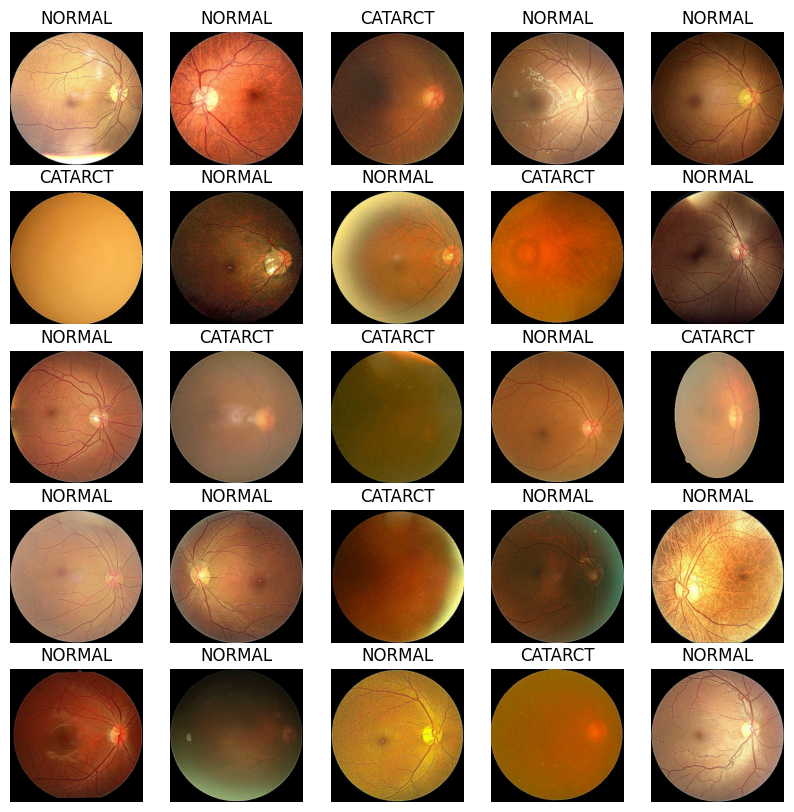

In [6]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for idx, img in enumerate(batch[0][:25]):
    row = idx//5
    col = idx%5
    
    axs[row, col].imshow(img.astype(int))
    axs[row, col].axis('off')
    axs[row, col].set_title('CATARCT' if batch[1][idx]==0 else 'NORMAL')

## Scaling Dataset

In [7]:
batch[0][0].shape, batch[0][0].max(), batch[0][0].min()

((256, 256, 3), 255.0, 0.0)

In [8]:
data = dataset.map(lambda x, y: (x/255, y))

In [9]:
print(data.as_numpy_iterator().next()[0][0].shape,
    data.as_numpy_iterator().next()[0][0].max(),
    data.as_numpy_iterator().next()[0][0].min())

(256, 256, 3) 1.0 0.0


## Splitting Dataset

In [10]:
len(data)

233

In [11]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)

train_size + val_size + test_size

233

In [12]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

## VGG16 Model

In [13]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [14]:
vgg = VGG16(input_shape=[256, 256] + [3], weights='imagenet', include_top=False)

In [15]:
for layer in vgg.layers:
    layer.trainaable = False

In [16]:
flatten = Flatten()(vgg.output)

prediction = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs=vgg.input, outputs=prediction)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [17]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

In [18]:
model_fit = model.fit(train_data, 
                       epochs=2, 
                       shuffle=True, 
                       validation_data=val_data)
                       # callbacks=[tfb_callback])

Epoch 1/2
163/163 [==============================] - 102s 475ms/step - loss: 1.0587 - accuracy: 0.5056 - val_loss: 0.6905 - val_accuracy: 0.5326
Epoch 2/2
163/163 [==============================] - 79s 487ms/step - loss: 0.6931 - accuracy: 0.5150 - val_loss: 0.6931 - val_accuracy: 0.5279


## Model Performance 

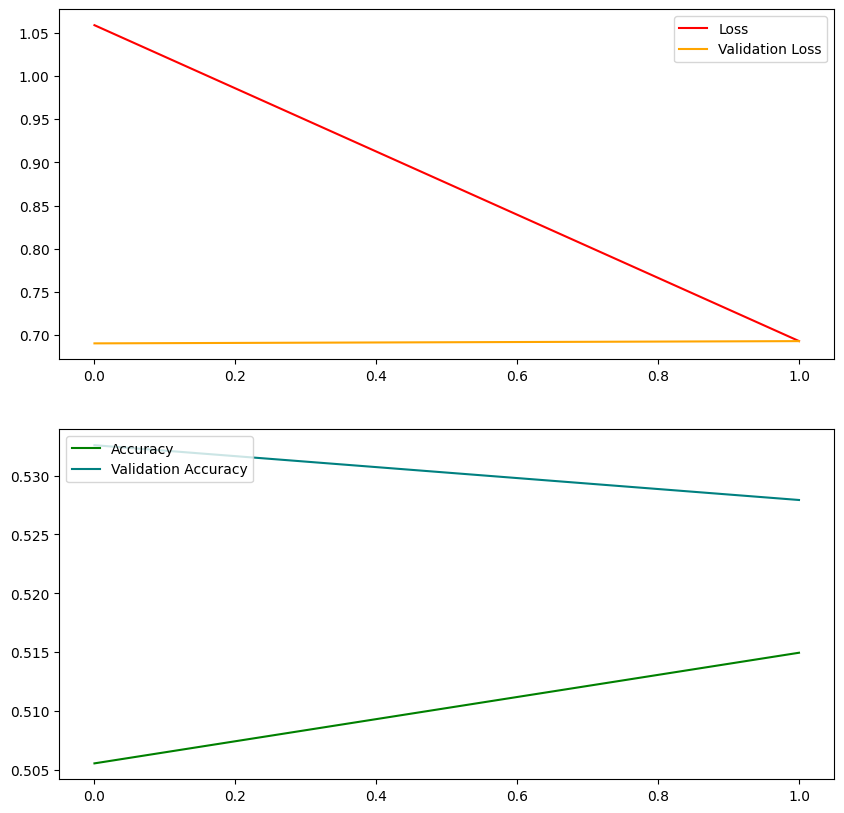

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(model_fit.history['loss'], color='red', label='Loss')
axs[0].plot(model_fit.history['val_loss'], color='orange', label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

## Evaluating Model

In [20]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

In [21]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)
    spe.update_state(y, y_pred)

1/1 [==============================] - 2s 2s/step


In [22]:
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', acc.result().numpy())
print('Precision\t:', precision)
print('Recall\t\t:', recall)
print('Specificity\t:', spe.result().numpy())
print('F1\t\t:', f1)

Accuracy	: 0.529986
Precision	: 0.529986
Recall		: 1.0
Specificity	: 0.0
F1		: 0.692798516617732


## Exporting Model

In [23]:
model.save(os.path.join('models', 'ODIR_VGG16.h5'))

In [24]:
from tensorflow.keras.models import load_model

model = load_model(os.path.join('models', 'ODIR_VGG16.h5'))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     